In [19]:
import pandas as pd
import numpy as np

df = pd.read_csv("merged_data.csv")
df.head()

,budget,runtime,Year,Month,GDP,INFLATION,INTEREST_RATE,director_past_avg_rev,Action,Adventure,...,overview_pca_40,overview_pca_41,overview_pca_42,overview_pca_43,overview_pca_44,overview_pca_45,overview_pca_46,overview_pca_47,overview_pca_48,overview_pca_49
0,7500000,103.0,2010.0,1.0,15048.971,1.640043,0.73,0.0,0,0,...,-0.017044,0.037198,-0.064563,0.020676,0.065429,-0.048382,-0.128791,0.075139,0.075847,0.083124
1,12500000,99.0,1996.0,1.0,8073.122,2.931204,5.02,0.0,0,0,...,-0.021330,-0.041371,-0.014677,0.004924,0.091164,-0.043685,-0.068544,0.022891,-0.124368,0.038199
2,1500000,97.0,2015.0,3.0,18295.019,0.118627,0.77,0.0,0,0,...,0.167959,-0.025022,-0.107306,-0.030180,0.072310,-0.044618,0.007216,0.098723,-0.050129,0.041407
3,3000000,87.0,1993.0,8.0,6858.559,2.951657,3.00,0.0,0,0,...,0.036006,0.053802,-0.069026,-0.111518,0.145948,0.000020,-0.020099,-0.124613,0.001808,-0.000265
4,26000000,94.0,2004.0,7.0,12217.196,2.677237,2.40,0.0,0,0,...,-0.052132,-0.067214,-0.096312,0.115198,-0.066432,0.038178,-0.016772,-0.142391,-0.134119,0.107727


In [20]:
from sklearn.model_selection import train_test_split

y = df['revenue']
X = df.drop('revenue', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

class LinearModel:
    def __init__(self):
        # pipeline does normalization
        self.model = Pipeline([
            ("scaler", StandardScaler()),
            ("reg", LinearRegression())
        ])
    
    def fit(self, X, y):
        """Train the linear regression model"""
        self.model.fit(X, y)
    
    def predict(self, X):
        """Predict outputs"""
        return self.model.predict(X)
    
    def evaluate(self, X, y):
        """Compute performance metrics"""
        y_pred = self.predict(X)
        metrics = {
            "R²": r2_score(y, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y, y_pred)),
            "MAE": mean_absolute_error(y, y_pred)
        }
        return metrics
    
    def summary(self, feature_names=None):
        """Display learned coefficients after scaling."""
        reg = self.model.named_steps["reg"]

        if feature_names is None:
            feature_names = [f"f{i}" for i in range(len(reg.coef_))]
        
        print("Intercept:", reg.intercept_)
        print("\nCoefficients:")
        for name, coef in zip(feature_names, reg.coef_):
            print(f"{name:25s} {coef:.4f}")

lm = LinearModel()
lm.fit(X_train,y_train)
#lm.summary()
preds = lm.predict(X_test)

metrics = lm.evaluate(X_test,y_test)
print("Model Performance: ", metrics)

Model Performance:  {'R²': 0.5775274736241938, 'RMSE': np.float64(117592688.5077693), 'MAE': 73385861.51913144}


In [24]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

class XGBModel:
    def __init__(self):
        self.model = XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42,
            tree_method="hist"
        )
    
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mae = mean_absolute_error(y, y_pred)
        return {"R²": r2, "RMSE": rmse, "MAE": mae}

# Training with hyperparameter tuning & cross-validation 
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

# Hyperparameter grid
param_dist = {
    "n_estimators":     [400, 700, 1000, 1300],
    "max_depth":        [3, 4, 5, 6],
    "learning_rate":    [0.01, 0.03, 0.05, 0.1],   
    "subsample":        [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 10],
    "reg_alpha":        [0, 0.01, 0.1, 1.0],
    "reg_lambda":       [0.5, 1, 5, 10],
    "gamma":            [0, 0.1, 0.3, 1.0],        
}

# 3-fold CV (randomized)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,                      
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best CV RMSE:", -random_search.best_score_)

# evaluate best model on test 
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("Test R²:  ", r2)
print("Test RMSE:", rmse)
print("Test MAE: ", mae)


# see top 20 most important features 
importances = best_xgb.feature_importances_
feat_importance = sorted(
    zip(X.columns, importances),
    key=lambda x: x[1],
    reverse=True
)

print("\nTop 50 features:")
for name, imp in feat_importance[:50]:
    print(f"{name:30s} {imp:.4f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best params: {'subsample': 0.6, 'reg_lambda': 5, 'reg_alpha': 1.0, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 1.0, 'colsample_bytree': 0.8}
Best CV RMSE: 121825984.0
Test R²:   0.6076474189758301
Test RMSE: 113323327.81506735
Test MAE:  68572888.0

Top 50 features:
budget                         0.0936
Adventure                      0.0445
director_past_avg_rev          0.0309
Drama                          0.0264
Animation                      0.0262
runtime                        0.0256
Fantasy                        0.0221
overview_pca_47                0.0202
overview_pca_3                 0.0181
overview_pca_41                0.0172
Year                           0.0160
overview_pca_30                0.0159
overview_pca_20                0.0154
Family                         0.0147
overview_pca_2                 0.0145
Science                        0.0144
overview_pca

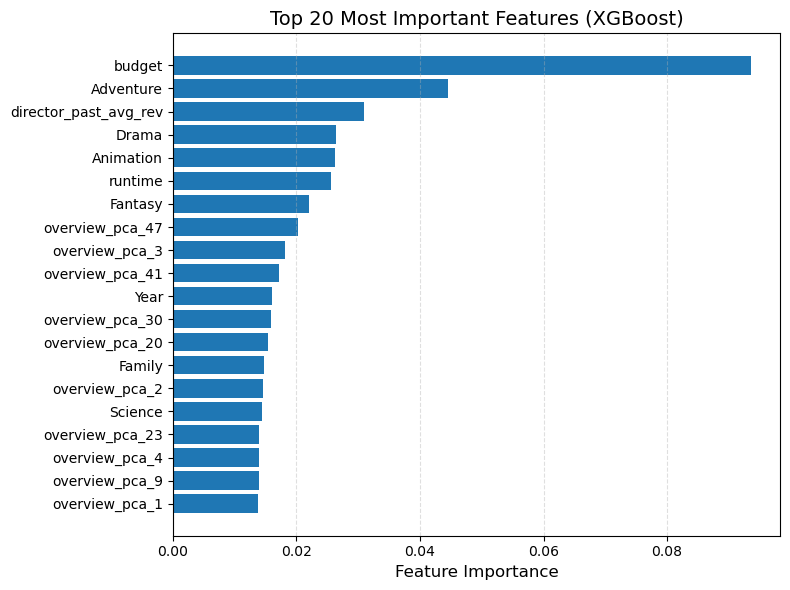

In [25]:
import matplotlib.pyplot as plt

# Get top 20 (already sorted above)
top20 = feat_importance[:20]

# plotting
feature_names, importance_values = zip(*top20)
feature_names = feature_names[::-1]
importance_values = importance_values[::-1]

plt.figure(figsize=(8, 6))
plt.barh(feature_names, importance_values)
plt.xlabel("Feature Importance", fontsize=12)
plt.title("Top 20 Most Important Features (XGBoost)", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

In [26]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

class PolyRegModel:
    def __init__(self, degree=2, alpha=1.0):
        """
        degree: polynomial degree (e.g., 1 = linear, 2 = quadratic with interactions)
        alpha:  L2 regularization strength (Ridge)
        """
        self.degree = degree
        self.alpha = alpha
        
        self.model = Pipeline([
            ("poly", PolynomialFeatures(degree=self.degree, include_bias=False)),
            ("scaler", StandardScaler()),
            ("reg", Ridge(alpha=self.alpha))
        ])
    
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mae = mean_absolute_error(y, y_pred)
        return {"R²": r2, "RMSE": rmse, "MAE": mae}
    
    @staticmethod
    def tune(X, y, cv=3, n_iter=10, random_state=42):

        base_pipe = Pipeline([
            ("poly", PolynomialFeatures(include_bias=False)),
            ("scaler", StandardScaler()),
            ("reg", Ridge())
        ])

        param_dist = {
            "poly__degree": [1, 2, 3],  
            "reg__alpha":  [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5],
        }

        search = RandomizedSearchCV(
            estimator=base_pipe,
            param_distributions=param_dist,
            n_iter=n_iter,
            scoring="neg_root_mean_squared_error",
            cv=cv,
            verbose=1,
            n_jobs=1,            
            random_state=random_state,
        )

        search.fit(X, y)

        best_degree = search.best_params_["poly__degree"]
        best_alpha = search.best_params_["reg__alpha"]

        best_model = PolyRegModel(degree=best_degree, alpha=best_alpha)
        best_model.model = search.best_estimator_

        return best_model, search
    

# Hyperparameter tuning on the train set
best_model, search = PolyRegModel.tune(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV RMSE:", -search.best_score_)

# Evaluate on test set
metrics = best_model.evaluate(X_test, y_test)
print("Test R²: ", metrics["R²"])
print("Test RMSE:", metrics["RMSE"])
print("Test MAE:", metrics["MAE"])


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'reg__alpha': 1, 'poly__degree': 1}
Best CV RMSE: 122346104.86232819
Test R²:  0.5775237330969343
Test RMSE: 117593209.0832574
Test MAE: 73378479.44779505
